In [61]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [62]:
# Define paths to dataset folders
base_dir = r'Z:\AAIT\interncareer\Computer Vision\Data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [63]:
# Define image size and paths
image_size = (224, 224) 
batch_size = 16  

In [64]:
# Training data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    vertical_flip = True, 
    fill_mode='nearest'  
)

# Validation and test data should not be augmented, only rescaled
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [65]:
# Prepare the data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical' 
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [66]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False
    

In [67]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # A dense layer with 512 units
x = Dropout(0.5)(x)  # Dropout layer for regularization
predictions = Dense(4, activation='softmax')(x)  # Softmax layer for classification

In [68]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

callbacks = [ tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,  patience=20, verbose=1, mode="auto", baseline=None, restore_best_weights=True)]

model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [69]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

Epoch 1/100
38/38 [==============================] - 32s 738ms/step - loss: 1.4156 - accuracy: 0.4774 - precision_8: 0.5125 - recall_8: 0.4121 - val_loss: 0.9251 - val_accuracy: 0.5000 - val_precision_8: 0.5750 - val_recall_8: 0.3594
Epoch 2/100
38/38 [==============================] - 26s 674ms/step - loss: 1.0132 - accuracy: 0.5592 - precision_8: 0.6258 - recall_8: 0.4704 - val_loss: 0.8876 - val_accuracy: 0.5469 - val_precision_8: 0.6667 - val_recall_8: 0.3125
Epoch 3/100
38/38 [==============================] - 26s 682ms/step - loss: 0.8773 - accuracy: 0.6030 - precision_8: 0.6846 - recall_8: 0.5126 - val_loss: 1.0197 - val_accuracy: 0.4375 - val_precision_8: 0.5435 - val_recall_8: 0.3906
Epoch 4/100
38/38 [==============================] - 26s 678ms/step - loss: 0.8299 - accuracy: 0.6198 - precision_8: 0.6897 - recall_8: 0.5025 - val_loss: 0.8573 - val_accuracy: 0.4844 - val_precision_8: 0.7917 - val_recall_8: 0.2969
Epoch 5/100
38/38 [==============================] - 25s 652ms/s

Epoch 36/100
38/38 [==============================] - 26s 669ms/step - loss: 0.4790 - accuracy: 0.7806 - precision_8: 0.8257 - recall_8: 0.7538 - val_loss: 0.7991 - val_accuracy: 0.6875 - val_precision_8: 0.7115 - val_recall_8: 0.5781
Epoch 37/100
38/38 [==============================] - 25s 668ms/step - loss: 0.5220 - accuracy: 0.7856 - precision_8: 0.8140 - recall_8: 0.7404 - val_loss: 0.8475 - val_accuracy: 0.7188 - val_precision_8: 0.7308 - val_recall_8: 0.5938
Epoch 38/100
38/38 [==============================] - 26s 684ms/step - loss: 0.5043 - accuracy: 0.7906 - precision_8: 0.8356 - recall_8: 0.7236 - val_loss: 0.7694 - val_accuracy: 0.7031 - val_precision_8: 0.7407 - val_recall_8: 0.6250
Epoch 39/100
38/38 [==============================] - 25s 659ms/step - loss: 0.4775 - accuracy: 0.7973 - precision_8: 0.8327 - recall_8: 0.7588 - val_loss: 0.7770 - val_accuracy: 0.7031 - val_precision_8: 0.7018 - val_recall_8: 0.6250
Epoch 40/100
38/38 [==============================] - 26s 68

In [70]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Test loss: {loss}, Test accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

20/20 [==============================] - 10s 506ms/step - loss: 0.7129 - accuracy: 0.6889 - precision_8: 0.7472 - recall_8: 0.6286
Test loss: 0.7128515839576721, Test accuracy: 0.6888889074325562, Precision: 0.7471697926521301, Recall: 0.6285714507102966


20/20 [==============================] - 12s 564ms/step


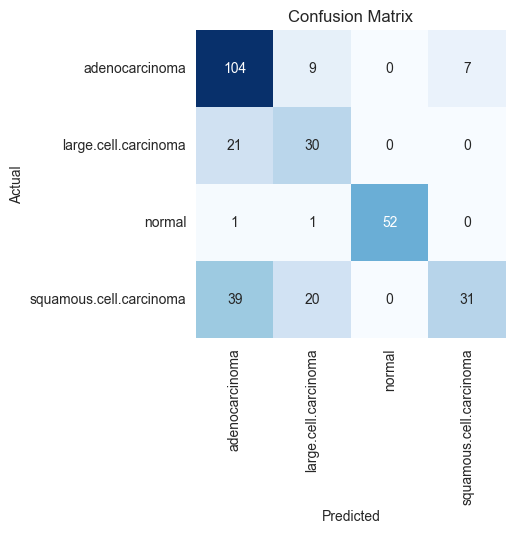

Classification Report:
----------------------
                          precision    recall  f1-score   support

         adenocarcinoma       0.63      0.87      0.73       120
   large.cell.carcinoma       0.50      0.59      0.54        51
                 normal       1.00      0.96      0.98        54
squamous.cell.carcinoma       0.82      0.34      0.48        90

               accuracy                           0.69       315
              macro avg       0.74      0.69      0.68       315
           weighted avg       0.73      0.69      0.67       315



In [71]:
# Predict classes on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Getting the mapping of classes

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# plot the confusion matrix
class_count = 4 
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, class_labels, rotation=90)
plt.yticks(np.arange(class_count)+.5, class_labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
report = classification_report(true_classes, predicted_classes, target_names=class_labels) # create classification report
print("Classification Report:\n----------------------\n", report)

